## Importing some stuff

- I am trying to find out the optimum reward function. For this I have created a fast forwarded rewards to check how the reward and tardiness behave. 

- Once I have created an optimum reward function for fast forward setup, i'll port that reward function to non-fast forwarded setup.

In [1]:
import simpy
import random
import gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import plotly.express as px

In [4]:
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common import make_vec_env
from stable_baselines import PPO2

/Users/suguthansekar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/suguthansekar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/suguthansekar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

/Users/suguthansekar/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, i

In [2]:
import gym 

import itertools 

import matplotlib 

import matplotlib.style 

import numpy as np 

import pandas as pd 

import sys 

from collections import defaultdict 
import plotting 
import numpy as np
  

matplotlib.style.use('ggplot') 

#### Functions

In [3]:
#Calculating moving average
def moving_average(numbers, window_size):
    i = 0
    moving_averages = []
    while i < len(numbers) - window_size + 1:
        this_window = numbers[i : i + window_size]

        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1
    return moving_averages

### Flow shop environment

In [ ]:
observation_space = gym.spaces.MultiDiscrete((3,3,3,3,21,21,21,21,3))

In [ ]:
observation_space = gym.spaces.Tuple((gym.spaces.Discrete(3),gym.spaces.Discrete(3),
                                                  gym.spaces.Discrete(3),gym.spaces.Discrete(3),
                                                  gym.spaces.Discrete(21),gym.spaces.Discrete(21),
                                                  gym.spaces.Discrete(21),gym.spaces.Discrete(21),
                                                  gym.spaces.Discrete(3)))

In [5]:
class flowshopGym:
    import random
    # --------------------------------------INITIALIZE THINGS------------------------------------------
    def __init__(self):
        self.NUM_PRODUCTS = 200
        self.IAT = 0.001 # change this to sample from some distribution
        self.action_space = gym.spaces.Discrete(4) # one action for each item in the production queue
        self.DEBUG = 1 # 1 = check simpy env ; 2 = check the openai processes
        self.tardiness_list = []
        self.mean_tard = [0]
        self.time_list = []
        self.time_bins = []
        #self.observation_space = gym.spaces.Discrete(9)
        # Rich observation space
        # Product type for the 4 product type, time left for the 4 products, product type in machine
        # For more details Thesis notes book on Notability
        self.observation_space = gym.spaces.Tuple((
                                                  gym.spaces.Discrete(3),gym.spaces.Discrete(3), # MC1 Queue prod type
                                                  gym.spaces.Discrete(3),gym.spaces.Discrete(3),
                                                  gym.spaces.Discrete(11),gym.spaces.Discrete(11), # MC1 Queue time left 
                                                  gym.spaces.Discrete(11),gym.spaces.Discrete(11),
                                                  gym.spaces.Discrete(3), # MC1 prod type
                                                  ))
        
        
        
        #self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        self.prod_and_requests = []
        self.machine_production = 0
        self.reward = 0 
        self.cumulative_reward = 0 
        self.machine1_prev_type = 0 # The previous product type in the machine
        self.QUEUE_LENGTH = 4
        self.DDF = 3
        self.metadata = []
        
        # The following two values from the setup time matrix
        self.P1_to_P2 = 10
        self.P2_to_P1 = 20
        
        # The range for the time converter
        self.TIME_MAX = 6000
        self.TIME_MIN = -6000
        
        self.state_format = 'Hosp'
    # --------------------------------------DEFINE PROCESSES------------------------------------------
    
    # Process 1 - Spawn of products
    def process_1(self):
        #print("Entered new product process")
        
        # Produce X number of products
        for i in range(self.NUM_PRODUCTS):
            
            # Creating instances of the product 
            ###print("creating instance", i)
            self.instances.append(self.product(self,self.envSimpy,'Product_%d' % i, self.store, self.machine))
            
            # IAT TIMEOUT BEFORE THE NEXT SPAWN
            #next_admission = random.expovariate(1 / interarrival_time)
            yield self.envSimpy.timeout(self.IAT)
        
        # After all the products are put into the store, start process 2
        # Process 2 - Getting products from the store and create machine request
        self.envSimpy.process(self.process_2())
    
    class product(object):
        def __init__(self, flowshopGym, envSimpy, name, number, machine):
            
            # Creating the required resources and environment
            self.envSimpy = envSimpy

            # State space variables
            self.prod_type = random.randint(1,2) # the product type of the product.
            #self.production_time = random.randint(5,15)
            self.production_time = 15
            
            
            # Rest of the variables
            
            # Using the method that Thomas said in rocketchat - TWK method
            # Formula is start time + sum of processing times * due date factor 
            # Due date factor is generally 3
            sim.TWK = self.envSimpy.now + self.production_time * sim.DDF # Total Work Content (TWK)
            self.production_due = sim.TWK
            #self.production_end = random.randint(np.ceil(self.envSimpy.now), np.ceil(TWK))
            self.name = name
            self.number = number
            self.machine = machine 
            
            ###print(self.name,"created")
            
            # putting the product into the store
            self.envSimpy.process(self.put_store())
            
 

        def put_store(self): # I am putting 
            yield sim.envSimpy.timeout(1)
            ###print("Putting the", self.name, "in the store at", self.envSimpy.now)
            yield sim.store.put(self)
            ###print("Items in the store",len(sim.store.items)," - time -",self.envSimpy.now)
            
        
    
    
    # -----------------------------PROCESS 2-------------------------------------------------  
    def process_2(self): # If machine.queue is less than 4, get a prod from store and create request

        while True:
            if len(self.machine.queue) < self.QUEUE_LENGTH:
                # Get product from store
                prod = yield self.store.get()
                
                TWK = self.envSimpy.now + prod.production_time * self.DDF # Total Work Content (TWK)
                prod.production_due = TWK
                # Request machine
                ###print("requesting machine for", prod.name)
                req = prod.machine.request()
                
                self.envSimpy.process(self.process_3(prod, req))
            else:
                yield self.envSimpy.timeout(1)
    
    def calc_setup_time(self, prod):
        #Setup process if required
        #returns the setup time

        #print("setup time ### ",self.machine1_prev_type , prod.prod_type, "at", self.envSimpy.now )
        if self.machine1_prev_type == 0:
            ###print("Previous machine type was 0")
            return 0 # dont' do anything during the first pass
        elif self.machine1_prev_type == prod.prod_type:
            ###print("Same product type between MC and incoming product")
            return 0 # Dont' do anything if the product types are the same 
        elif prod.prod_type == 2: # current product type = 2 meaning we have to do a changeover from 1 to 2
            ###self.reward = self.reward - 5 # -ve reward when there is a setup change
            return self.P1_to_P2
            ###print("Setup time prod1 to prod2 finished at",self.envSimpy.now )
        elif prod.prod_type == 1: # current product type = 1 meaning we have to do a changeover from 2 to 1
            ###self.reward = self.reward - 5 # -ve reward when there is a setup change
            return self.P2_to_P1
            ###print("Setup time prod2 to prod1 finished at",self.envSimpy.now )
        else:
            raise Exception("Sorry product type doesn't match available values [for Setup process]")
        
    # -----------------------------PROCESS 3-------------------------------------------------  
    def process_3(self,prod, req): # Wait for req to go through and then produce and release the machine  
        sim.prod_and_requests.append([prod,req])
        # Wait for the request to succeed
        yield req
        
        #if len(self.machine.queue) > 0:
            #for i in (self.machine.queue):
                #print("Time left",self.time_left(self.relater(i).production_due))
             #   pass
            #print('\n')


        
        prod.production_start = sim.envSimpy.now
        # Fast Forwarding reward
        setup_time = self.calc_setup_time(prod)
        production_start = self.envSimpy.now
        projected_production_end = production_start + setup_time + prod.production_time
        
        prod.tardiness = projected_production_end - prod.production_due # actual end time - deadline 
        #prod.tardiness = max(0, projected_production_end - prod.production_due) # actual end time - deadline 
        self.info['Tardiness'] = prod.tardiness
        #print("Prod start, setup, production_time, tardiness",production_start, setup_time, prod.production_time, prod.tardiness)
        #sim.reward = max(0,prod.tardiness)
        # Decide the reward 
        #sim.reward = - (prod.tardiness) 
        #if prod.tardiness == 0:
        #    sim.reward = sim.reward + 10
        #else:
        #    sim.reward = sim.reward + 0
            
        if prod.tardiness <= 70:
            sim.reward = sim.reward + 10 
        else: 
            sim.reward = sim.reward + 0
        
        ###sim.reward -= (setup_time)
        ###sim.reward -= ((prod.production_time)/10)         
        yield self.envSimpy.timeout(setup_time)
        #print("Time after setup time", self.envSimpy.now)
        
        # ----------------------------
        ###print('Start production of ' + str(prod.name) + ' at '+ str(self.envSimpy.now)  )

        ###print("Production time", prod.production_time)
        self.machine_production = 1
        
        yield self.envSimpy.timeout(prod.production_time)
        prod.production_end = sim.envSimpy.now
        ###print('Production fini shed at' + str(self.envSimpy.now))
        
        
        
        
        # Changing the previous prod_type on the machine
        self.machine1_prev_type = prod.prod_type
        
         
        # Tardiness = Actual prod time - due date
        #prod.tardiness = prod.production_end - prod.production_due      # +ve is bad; -ve is good
        
        #self.info['Tardiness'] = prod.tardiness
        self.tardiness_list.append(prod.tardiness)
        self.mean_tard.append(np.mean(self.tardiness_list))

        #sim.reward +=  10 # Reward to finish products #ddf
        #sim.reward += ((- prod.tardiness)/10)
        ###sim.reward = max(0,prod.tardiness)
        # Reward function 1 --> Reward = - tardiness 
        #if prod.tardiness <= 0:
        #    sim.reward = (-1 * prod.tardiness) #sim.reward +  50
        #else:
        #    sim.reward = sim.reward + 0 
        
        # Reward function  
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward +  50#(-1 * prod.tardiness)
        #else:
        #    sim.reward = sim.reward  - 50         
        
        # Reward function 2 --> Reward = -(mean_tardiness[-1])
        #sim.reward = sim.reward - (self.mean_tard[-1])            
        
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward +  50#(-1 * prod.tardiness)
        #else:
        
        # Reward function
        #sim.reward = sim.reward + (-prod.tardiness)
        
        # Reward function
        #if prod.tardiness <= 0:
        #    sim.reward = sim.reward + (prod.tardiness)**2
        #else:
        #    sim.reward = sim.reward - (prod.tardiness)
        
        # Reward function (works)
        #if prod.tardiness <= 0: # 50 is the mean tardiness observed without any reward 
        #    sim.reward = sim.reward + 50
        #else:
        #    pass
        
        
            #sim.reward = sim.reward - 50
        
        # Reward function (kinda works)
        #if self.mean_tard[-1] < self.mean_tard[-2]: # if the mean tardiness is decreasing, then...
        #    sim.reward = sim.reward + 50
        #else:
        #    pass
        
        # Reward function (doesn't work)
        #if prod.tardiness <= 0: 
        #    sim.reward = - (prod.tardiness)
        #else:
        #    pass
            #sim.reward = sim.reward - 50
        
        # Reward function (Doesn't work)
        #sim.reward = - prod.tardiness
        
        #if prod.tardiness <= 0: # 50 is the mean tardiness observed without any reward 
        #    sim.reward = sim.reward - prod.tardiness
        #else:
        #    pass
        
        # End of production 
        #print('End production of ' + str(prod.name) + ' at ' + str(self.envSimpy.now))

        # Before Saturday, 3 April 2021
        #sim.reward -= (setup_time)
        #sim.reward -= ((prod.production_time)/10)
        #sim.reward +=  10 # Reward to finish products #ddf
        #sim.reward += ((- prod.tardiness)/10)
        
        # Wait for an acceptance only when there are products in the machine.queue
        if len(sim.machine.queue) != 0: # if there items in the machine queue
            self.machine_production = 0
            # 1. After production pass the time so that the agent can take action based on the latest state
            # 2. Pass time when the action chosen by the agent is rejection
            i = 0
            while True:
                if i == 0:
                    yield self.envSimpy.timeout(1)
                    #print("Timeout after production")
                i += 1

                
                ###print("Initial queue", sim.machine.queue)
                ###print("Initial queue LENGTH", len(sim.machine.queue))
                ###print("Current_action", sim.current_action)
                #print("\n")
                #print("Selected action", sim.current_action)
                #print("sim.machine.queue", sim.machine.queue)
                if sim.current_action > (len(sim.machine.queue)-1): # action is invalid:
                    #print("Invalid action")
                    sim.reward -= -5 
                    yield self.envSimpy.timeout(1)
                else:
                    # Put's the action product in the first position
                    sim.machine.queue.insert(0,sim.machine.queue.pop(sim.current_action)) 
                    #print("valid action, updated mc queue", sim.machine.queue)
                    break

        else:
            pass


        

        #print("Tardiness is ",prod.tardiness)
        # Production has ended now I have to take the next action using take_action()
        # envGym.machine.queue = envGym.take_action()
        #envGym.machine.queue = []

        # Release the machine
        #yield prod.machine.release(req)
        
        # Release the machine
        yield prod.machine.release(req)

        # timeout before the next check
        #yield env.timeout(1)
    # ----------------------------------------------------------------------------------------------
    # --------------------------------------DEFINE FUNCTIONS------------------------------------------
    # ----------------------------------------------------------------------------------------------
    
    def getObs(self): 
        # CREATING TUPLE/DICT TO HOLD INFO        
        test_state = dict()
        
        # Machine 1 product type - Initial value
        test_state['MC1_prod_type'] = 0
        # Machine 1 queue product type - Initial values
        test_state['MC1_queue1_type'] = 0
        test_state['MC1_queue2_type'] = 0
        test_state['MC1_queue3_type'] = 0
        test_state['MC1_queue4_type'] = 0 
        # Machine 1 queue time left - Initial values
        test_state['MC1_queue1_timeleft'] = 0
        test_state['MC1_queue2_timeleft'] = 0
        test_state['MC1_queue3_timeleft'] = 0
        test_state['MC1_queue4_timeleft'] = 0
        
        # 1. PRODUCT TYPE INSIDE THE MACHINE
        if len(sim.machine.users) != 0: #if the machine is not empty
            test_state['MC1_prod_type'] = (self.relater(sim.machine.users[0])).prod_type # Product type of the product inside machine 1
        else:
            pass # No product inside the machine
        if self.machine_production == 0: # if we enter the loop 
            test_state['MC1_prod_type'] = 0
        
        # 2. PRODUCT TYPE IN MACHINE 1 QUEUE
        if len(sim.machine.queue) == 0: # queue is empty
            pass # Already defined these values while creating the dict()

        elif len(sim.machine.queue) == 1:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
        elif len(sim.machine.queue) == 2:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
            # Machine 1 queue2 product type
            test_state['MC1_queue2_type'] = (self.relater(sim.machine.queue[1])).prod_type
        
        elif len(sim.machine.queue) == 3:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
            # Machine 1 queue2 product type
            test_state['MC1_queue2_type'] = (self.relater(sim.machine.queue[1])).prod_type
            
            # Machine 1 queue3 product type
            test_state['MC1_queue3_type'] = (self.relater(sim.machine.queue[2])).prod_type
        
        elif len(sim.machine.queue) == 4:
            # Machine 1 queue1 product type
            test_state['MC1_queue1_type'] = (self.relater(sim.machine.queue[0])).prod_type
            
            # Machine 1 queue2 product type
            test_state['MC1_queue2_type'] = (self.relater(sim.machine.queue[1])).prod_type
            
            # Machine 1 queue3 product type
            test_state['MC1_queue3_type'] = (self.relater(sim.machine.queue[2])).prod_type
            
            # Machine 1 queue4 product type
            test_state['MC1_queue4_type'] = (self.relater(sim.machine.queue[3])).prod_type
        
        else:
            raise Exception("Queue length incompatible")

        
        # 3. TIME LEFT CALCULATION
        # for each position
        if test_state['MC1_queue1_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[0])).production_due)
            test_state['MC1_queue1_timeleft'] = self.time_convert(time_left)
                
        if test_state['MC1_queue2_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[1])).production_due)
            test_state['MC1_queue2_timeleft'] = self.time_convert(time_left)
        
        if test_state['MC1_queue3_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[2])).production_due)
            test_state['MC1_queue3_timeleft'] = self.time_convert(time_left)
        
        if test_state['MC1_queue4_type'] != 0: # product present
            time_left = self.time_left((self.relater(sim.machine.queue[3])).production_due)
            test_state['MC1_queue4_timeleft'] = self.time_convert(time_left)
            
        obs = [v for k,v in test_state.items()]    
        #print("------ obs ", tuple(obs))
        
        return tuple(obs)
    
    def time_left(self, due):
        #print("due, time now", (due- sim.envSimpy.now))
        return (due - sim.envSimpy.now)
    
    def time_convert(self, time):
        #print("Time to convert",time)
        time_max = 100 #self.TIME_MAX
        time_min = -100 #self.TIME_MIN

        if time < -100:
            self.time_bins.append(0)
            return 0
        
        if time_min < time <= time_max:
            self.time_list.append(time)
            min_max_time = (time-time_min)/(time_max-time_min)
            scaled_time = min_max_time * 10 # Scaling time to be between 0 and 20
            self.time_bins.append(int(np.ceil(scaled_time)))
            #print(time,int(np.ceil(scaled_time)) )
            return int(np.ceil(scaled_time))
        else:
            raise Exception("Input time value outside range in def time_convert")
            
            

    
     
    def encode(self, obs):
        #print('Entered encode')
        # (3), 3 [Machine queue type, machine product type]
        i = obs[0] 
        i *= 3
        
        i += obs[1]
        #print("Value of i inside encode ", i)
        return i
    
    def doneFn(self):
        # So the condition is, 
        #(no items in queue1 + queue2 + ...) AND 
        #(no machine is running)
        if self.machine.queue != None:
            lenQueue = len(self.machine.queue)
        else: 
            lenQueue = 0 
        lenMachinesUsed = self.machine.count
        #print("Queue length",lenQueue, "no machines used", lenMachinesUsed)

        if (self.envSimpy.now) > self.TIME_MAX: # Early break if time crosses the TWK; Breaking 3 time steps early
            self.early_break = True
        else:
            self.early_break = False

        if (lenQueue == 0 and lenMachinesUsed == 0) or (self.early_break == True) :
            #print("length of queue ",lenQueue,"Machines used ", lenMachinesUsed)
            #print("###now, TWK", self.envSimpy.now, self.TWK)
            return True
        else:
            #print("length of queue ",lenQueue,"Machines used ", lenMachinesUsed)
            return False

    
    # A function to relate products and requests
    def relater(self,item):
        # Note that the input to this function shouldn't be a list. It should be of 
        # type request or product
        #print("Entered relater with this item ###", item, type(item))
        output_item = None
        
        if str(type(item)) != "<class '__main__.flowshopGym.product'>" and str(type(item)) != 'simpy.resources.resource.Request':
            raise Exception("Passed in a list to relater. Expecting request or product object")
            #print("Error passed in a list. Expecting request or product object")
            return None
        # If the input is a request
        #print("self.prod_and_requests", self.prod_and_requests)
        if type(item) == simpy.resources.resource.Request:
            for i, j in enumerate(self.prod_and_requests):
                if j[1] == item:
                    output_item = j[0]
                    return output_item
        else: #if the input is a product 
            for i, j in enumerate(self.prod_and_requests):
                if j[0] == item:
                    output_item = j[1]
                    return output_item   
    
    
    # --------------------------------------RENDER------------------------------------------
    
    
    
    
    # --------------------------------------RESET------------------------------------------
    def reset(self):
        #print("Entered Reset")
        # Initialise simpy environemnt and a machine
        self.envSimpy = simpy.Environment()
        self.machine = simpy.Resource(self.envSimpy,capacity = 1)
        self.store = simpy.Store(self.envSimpy) 
        
        # Initial variable definitions
        self.time_start = self.envSimpy.now
        self.next_time_stop = self.time_start + 1
        self.time_step = 1
        self.time_step_terminal = self.time_start + 100
        self.current_action = 0
        self.instances = []
         
        # Set up starting processes
        self.envSimpy.process(self.process_1())
        
        # Set starting state values

        
        # Inital load of patients (to average occupancy)
        #self._load_patients()
        
        # Starting values of observations
        observations = self.getObs()
        
        # Put state dictionary items into observations list (Define observations)
        #observations = [v for k,v in self.state.items()]
        return observations
    
    
    
    
    # --------------------------------------STEP------------------------------------------
    
    def step(self, action):
        
        # Define params
        self.current_action = action
        self.action_taken = False 
        self.info = {}
        sim.reward = 0 
        
        # Reward based on the production status
        #if self.machine_production == 1:  
        #    self.reward = -1 # a simple negative reward when the machine is waiting for a decision 
        #    if self.current_action == 0 or self.current_action == 1: # action is accepted or rejected
        #        self.reward = self.reward -20
        #        print("### wrong action")
        
        #print("machine is used by",sim.machine.users)
        #print("machine production status", self.machine_production)
        #print("Agent action", action)
        # Run for time_step
        self.next_time_stop += self.time_step
        self.envSimpy.run(until = self.next_time_stop)
        
        
        
        # Get values
        observation = self.getObs()
        done = self.doneFn()
        
        
        # each step has a -1 reward 
        #self.reward = self.reward - 1 
        

        
        if done == True and self.early_break != True:
            print(self.envSimpy.now)
            #self.reward = self.reward + 3000 # Very high reward for completing all jobs
        info = self.info
        self.cumulative_reward += self.reward
        #print("Reward",self.reward)
        #print("Values from Step",observation, sim.reward, done, info)
        # Return values
        return (observation, self.reward, done, info)

        
    

#### Random agent

In [6]:
sim = flowshopGym()
state = sim.reset()
epochs = 0
penalties, reward, epoch_reward = 0, 0, 0 
epsilon = 0.1
done = False
tardiness = []
CMAX = [] # cmax is the maximum make span. This is the most widely used measure in flowshops

while not done:
    
    # Random action
    action = sim.action_space.sample()
    
    # FIFO
    #action = 0
    
    
    #action = np.argmax(Q1[state])
    #if random.uniform(0, 1) < epsilon:
    #    action = sim.action_space.sample() # Explore action space
    #else:
    #    action = np.argmax(Q1[state]) # Exploit learned values
    ###print("###Taking an action at", sim.envSimpy.now)
    state, reward, done, info = sim.step(action)
    if reward == 0:
        penalties += 1
    try:
        tardiness.append(info['Tardiness'])
    except:
        pass
    
    epoch_reward += reward
    

    epochs += 1


mean_tardiness = sum(tardiness)/(len(tardiness))
print("End time is ", sim.envSimpy.now)
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))
print("Epoch reward ", epoch_reward)
print("Mean tardiness of epoch ", mean_tardiness, "(-ve is good)")
#print("Median")

4573
End time is  4573
Timesteps taken: 4572
Penalties incurred: 4438
Epoch reward  1330
Mean tardiness of epoch  66.90604999999977 (-ve is good)


#### Random - 51 epochs

In [ ]:
from stable_baselines.common.vec_env import DummyVecEnv

In [ ]:
%%time
sim = flowshopGym()
#sim = DummyVecEnv([lambda: sim]) # vectorization of the environment
#sim.reset()

"""Training the agent"""

import random
from IPython.display import clear_output


# For plotting metrics
all_epochs_random = []
all_penalties_random = []
all_rewards_random = []
all_tardiness_random = []
CMAX = []

for i in range(1, 101):
    print(i)
    state = sim.reset()

    epochs, penalties, reward, episodic_reward, tardiness = 0, 0, 0, 0, []
    done = False
    
    while not done:
        action = 0
        #action = random.randint(0,2)
        next_state, reward, done, info = sim.step(action) 
        ###print("state, action", state, action)
        
        episodic_reward += reward
        
        if reward <= 0:
            penalties += 1
        
        state = next_state
        epochs += 1
        
        try:
            ###print(info['Tardiness'])
            tardiness.append(info['Tardiness'])
        except:
            pass

    all_epochs_random.append(i)
    all_penalties_random.append(penalties)
    all_rewards_random.append(episodic_reward)
    all_tardiness_random.append(np.mean(tardiness))
    #CMAX.append(max(tardiness))
    CMAX.append(sim.envSimpy.now)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

In [ ]:
plt.scatter(all_epochs_random, CMAX)
plt.show()

In [ ]:
np.mean(all_tardiness_random[-20:]), np.mean(all_rewards_random[-20:])

In [ ]:
plt.plot(all_epochs_random[-20:],all_rewards_random[-20:])

In [ ]:
plt.plot(all_epochs_random,all_tardiness_random)

### Overall flow - Q-learning 

#### Q-learning


In [19]:
%%time
Q1 = defaultdict(lambda: np.zeros(sim.action_space.n)) 
sim = flowshopGym()
#sim.reset()

"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon_init = 0.3
beta = 0.0009

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []
all_tardiness = []
all_steps = []
CMAX = []

for i in range(1, 201):
    print(i)
    
    epsilon = epsilon_init - beta * i
    if epsilon < 0:
        raise Exception("Epsilon value less than zero. Tweak beta value according to no. epochs")
    sim = flowshopGym()
    state = sim.reset()
    steps = []
    epochs, penalties, reward, episodic_reward, tardiness = 0, 0, 0, 0, []
    done = False
    episodic_reward_list = []
    step = 0
    while not done:
        step += 1
        
        if random.uniform(0, 1) < epsilon:
            action = sim.action_space.sample() # Explore action space
        else:
            action = np.argmax(Q1[state]) # Exploit learned values
        
        next_state, reward, done, info = sim.step(action) 
        #print("state, action, reward", state, action, reward)
        old_value = Q1[state][action]
        next_max = np.max(Q1[next_state])
        
        new_value =  old_value + alpha * (reward + (gamma * next_max) - old_value)
        Q1[state][action] = new_value
        
        episodic_reward += reward
        episodic_reward_list.append(reward)
        
        if reward <= 0:
            penalties += 1
        
        state = next_state
        epochs += 1
        steps.append(step)
        try:
            #print(info['Tardiness'])
            tardiness.append(info['Tardiness'])
        except:
            pass
    
    #print("Reward for this episode", episodic_reward)
    all_steps.append(steps)
    all_epochs.append(i)
    all_penalties.append(penalties)
    all_rewards.append(episodic_reward)
    all_tardiness.append(np.mean(tardiness))
    #CMAX.append(max(tardiness))
    CMAX.append(sim.envSimpy.now)
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

Episode: 200
Training finished.

CPU times: user 3min 42s, sys: 4.17 s, total: 3min 46s
Wall time: 3min 52s


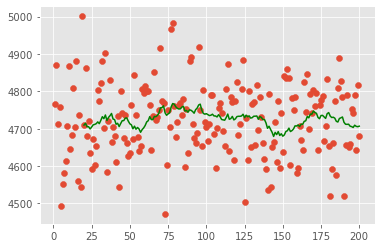

In [20]:
plt.scatter(all_epochs, CMAX)
plt.plot(all_epochs[19:],moving_average(CMAX,20), color = 'green')
plt.show()

In [21]:
len(sim.tardiness_list)

200

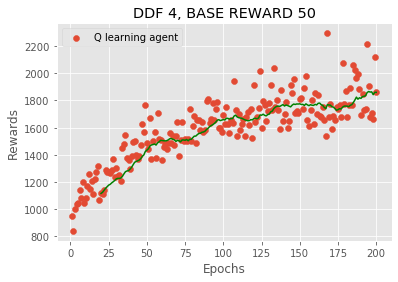

In [22]:
plt.scatter(all_epochs,all_rewards, label = "Q learning agent")
plt.plot(all_epochs[19:],moving_average(all_rewards,20), color = 'green')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("DDF 4, BASE REWARD 50")
plt.show()

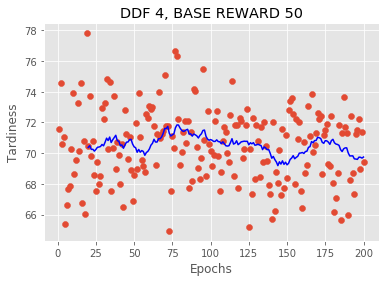

In [23]:
plt.scatter(all_epochs,all_tardiness)
plt.plot(all_epochs[19:],moving_average(all_tardiness, 20), color = 'blue')

plt.xlabel("Epochs")
plt.ylabel("Tardiness")
plt.title("DDF 4, BASE REWARD 50")
plt.show()


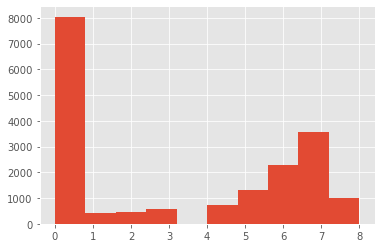

In [24]:
plt.hist(sim.time_bins)
plt.show()

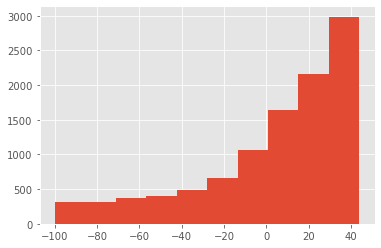

In [25]:
plt.hist(sim.time_list)
plt.show()

Tardiness for each product in the last epoch

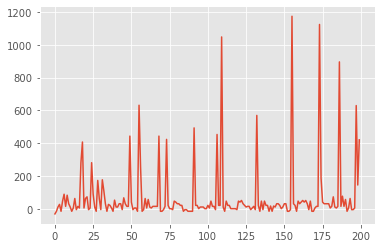

In [26]:
plt.plot(sim.tardiness_list)
plt.show()


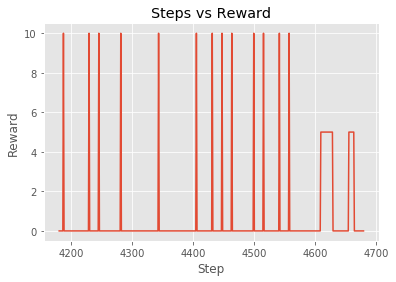

In [27]:
#For the last epoch
plt.plot(steps[-500:],episodic_reward_list[-500:])

plt.xlabel("Step")
plt.ylabel("Reward")
plt.title("Steps vs Reward")
plt.show()

In [28]:
np.mean(all_tardiness[-20:]),np.mean(all_rewards[-20:])


(69.74930000000008, 1860.0)

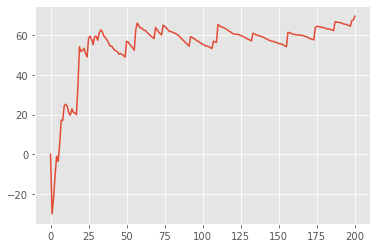

In [29]:
plt.plot(sim.mean_tard)
plt.show()

### System states

In [ ]:
len(sim.tardiness_list)

In [ ]:
for i in range(len(sim.prod_and_requests)):
    print(sim.prod_and_requests[i][0].production_start, sim.prod_and_requests[i][0].production_end, sim.prod_and_requests[i][0].production_due)

In [ ]:
# Run this notebook and then run the Binary notebook

### Comparing the Random agent and the Q learning agent

#### Mean Tardiness and Mean Rewards 

Random agent

In [ ]:
np.mean(all_tardiness_random[-20:]),np.mean(all_rewards_random[-20:])

Q learning agent

In [ ]:
np.mean(all_tardiness[-20:]),np.mean(all_rewards[-20:])

#### Tardiness

In [ ]:
plt.scatter(all_epochs,all_tardiness, label = "Q learning agent")
plt.plot(all_epochs[9:],moving_average(all_tardiness,10), color = 'green')

plt.scatter(all_epochs_random,all_tardiness_random, label = "Random agent")
plt.plot(all_epochs_random[9:],moving_average(all_tardiness_random,10), color = 'blue')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Tardiness")
plt.title("Epochs vs Tardiness")
plt.show()

#### Rewards

In [ ]:
plt.scatter(all_epochs,all_rewards, label = "Q learning agent")
plt.plot(all_epochs[9:],moving_average(all_rewards,10), color = 'green')

plt.scatter(all_epochs_random,all_rewards_random, label = "Random agent")
plt.plot(all_epochs_random[9:],moving_average(all_rewards_random,10), color = 'blue')

plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Rewards")
plt.title("Epochs vs Rewards - All epochs")
plt.show()

In [ ]:
len(Q1)

In [ ]:
Q1

### PPO

In [7]:
sim = flowshopGym()
state = sim.reset()

In [8]:
model = PPO2(MlpPolicy, sim, verbose=1)
model.learn(total_timesteps=25000)

Wrapping the env in a DummyVecEnv.


NotImplementedError: Error: the model does not support input space of type Tuple

### Exploitation of Q1


In [ ]:
%%time
Q1 = defaultdict(lambda: np.zeros(sim.action_space.n)) 
sim = flowshopGym()
#sim.reset()

"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.3

# For plotting metrics
all_epochs = []
all_penalties = []
all_rewards = []
all_tardiness = []
all_steps = []

for i in range(1, 301):
    print(i)
    sim = flowshopGym()
    state = sim.reset()
    steps = []
    epochs, penalties, reward, episodic_reward, tardiness = 0, 0, 0, 0, []
    done = False
    episodic_reward_list = []
    step = 0
    while not done:
        step += 1
        
        action = np.argmax(Q1[state]) # Exploit learned values
        
        next_state, reward, done, info = sim.step(action) 
        
        
        episodic_reward += reward
        episodic_reward_list.append(reward)
        
        if reward <= 0:
            penalties += 1
        
        state = next_state
        epochs += 1
        steps.append(step)
        try:
            #print(info['Tardiness'])
            tardiness.append(info['Tardiness'])
        except:
            pass
    
    all_steps.append(steps)
    all_epochs.append(i)
    all_penalties.append(penalties)
    all_rewards.append(episodic_reward)
    all_tardiness.append(np.mean(tardiness))
        
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")

In [ ]:
np.mean(all_tardiness[-20:]),np.mean(all_rewards[-20:])

In [ ]:
plt.plot(all_epochs,all_rewards)

In [ ]:
plt.scatter(all_epochs,all_tardiness)
plt.plot(all_epochs[9:],moving_average(all_tardiness, 10), color = 'blue')
plt.show()

In [ ]:
# Reward is 
if prod.tardiness <= 0: # 50 is the mean tardiness observed without any reward 
    sim.reward = sim.reward + 50
else:
    pass

# check for the performance the models

# next reward = - tardiness

# check papers for how they define reward